In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

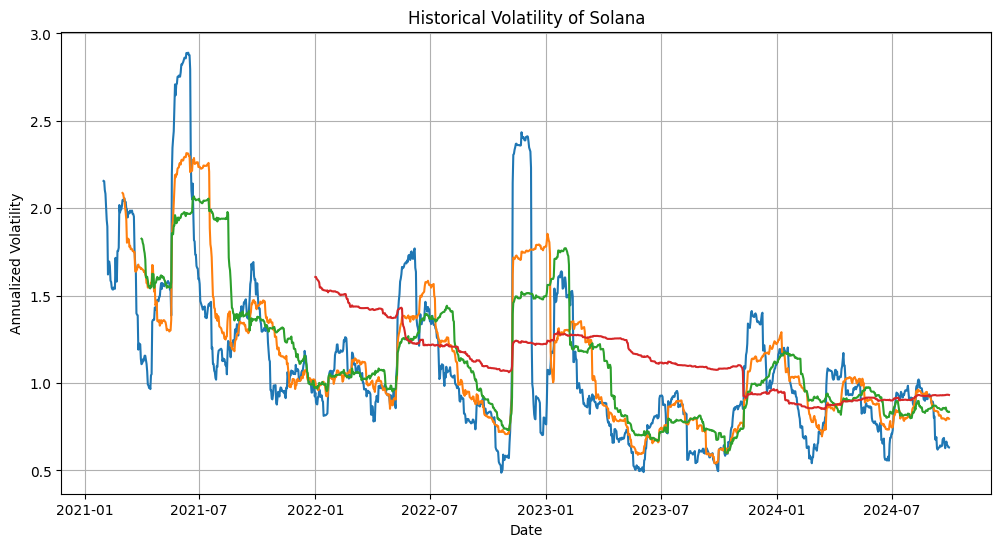

In [3]:
# Computing historical volatility using data from Kaggle (https://www.kaggle.com/datasets/heidarmirhajisadati/solana-historical-data-2021-2024?resource=download)
def calculate_historical_volatility(prices, window=30):
    """
    Calculate historical volatility from a series of prices
    
    Args:
        prices: Series of prices
        window: Rolling window in days for volatility calculation
        
    Returns:
        Series of annualized volatility values
    """
    # Calculate daily returns
    returns = np.log(prices / prices.shift(1))
    
    # Calculate rolling standard deviation of returns
    rolling_std = returns.rolling(window=window).std()
    
    # Annualize the volatility (multiply by sqrt of trading days in a year)
    annualized_vol = rolling_std * np.sqrt(365)
    
    return annualized_vol

# Read the CSV data
df = pd.read_csv('Solana_daily_data_2018_2024.csv')
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

# Calculate historical volatility
df['volatility_30d'] = calculate_historical_volatility(df['Close'], window=30)
df['volatility_60d'] = calculate_historical_volatility(df['Close'], window=60)
df['volatility_90d'] = calculate_historical_volatility(df['Close'], window=90)
df['volatility_365d'] = calculate_historical_volatility(df['Close'], window=365)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['volatility_30d'])
plt.plot(df.index, df['volatility_60d'])
plt.plot(df.index, df['volatility_90d'])
plt.plot(df.index, df['volatility_365d'])
plt.title('Historical Volatility of Solana')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.grid(True)
plt.show()

In [14]:
def get_put_price(current_price, strike_price, time_to_maturity, risk_free_rate, sigma):
    """
    Computes the price of a put option for the DAO.
    It takes the price of the put according to BS model but accounts for the fact that the interests are paid by the DAO.
    """

    d1 = (
        np.log(current_price / strike_price)
        + (risk_free_rate + sigma**2 / 2) * time_to_maturity
    ) / (sigma * np.sqrt(time_to_maturity))
    d2 = d1 - sigma * np.sqrt(time_to_maturity)
    base_put_price = strike_price * np.exp(-risk_free_rate * time_to_maturity) * norm.cdf(
        -d2
    ) - current_price * norm.cdf(-d1)
    collateral_value = min(strike_price, current_price)
    interest_cost = risk_free_rate * time_to_maturity * current_price

    return base_put_price + interest_cost + collateral_value

def get_put_price_components(current_price, strike_price, time_to_maturity, risk_free_rate, sigma):
    """
    Computes the price of a put option for the DAO.
    It takes the price of the put according to BS model but accounts for the fact that the interests are paid by the DAO.
    """

    d1 = (
        np.log(current_price / strike_price)
        + (risk_free_rate + sigma**2 / 2) * time_to_maturity
    ) / (sigma * np.sqrt(time_to_maturity))
    d2 = d1 - sigma * np.sqrt(time_to_maturity)
    base_put_price = strike_price * np.exp(-risk_free_rate * time_to_maturity) * norm.cdf(
        -d2
    ) - current_price * norm.cdf(-d1)
    collateral_value = min(strike_price, current_price)
    interest_cost = risk_free_rate * time_to_maturity * current_price

    return (base_put_price, interest_cost, collateral_value)

In [15]:
volatility_low = 1
volatility_high = 3

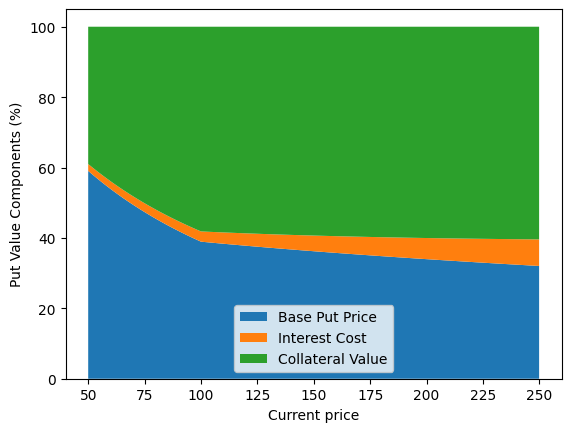

In [20]:
strike_price = 100
interest_rate = 0.1
time_to_maturity = 0.5

S = np.arange(50,250,0.1)

# Get components for each price point
components = [get_put_price_components(s, strike_price, time_to_maturity, interest_rate, volatility_high) for s in S]

# Split into separate arrays
base_puts = [c[0] for c in components]
interest_costs = [c[1] for c in components] 
collateral_values = [c[2] for c in components]

# Convert to percentages
totals = [b + i + c for b,i,c in zip(base_puts, interest_costs, collateral_values)]
base_puts_pct = [b/t * 100 for b,t in zip(base_puts, totals)]
interest_costs_pct = [i/t * 100 for i,t in zip(interest_costs, totals)]
collateral_values_pct = [c/t * 100 for c,t in zip(collateral_values, totals)]

# Create cumulative percentage plot
plt.stackplot(S, 
              base_puts_pct,
              interest_costs_pct, 
              collateral_values_pct,
              labels=['Base Put Price', 'Interest Cost', 'Collateral Value'])

plt.xlabel('Current price')
plt.ylabel('Put Value Components (%)')
plt.legend()

In [21]:
interest_costs_pct[500]

np.float64(2.9077218499673654)

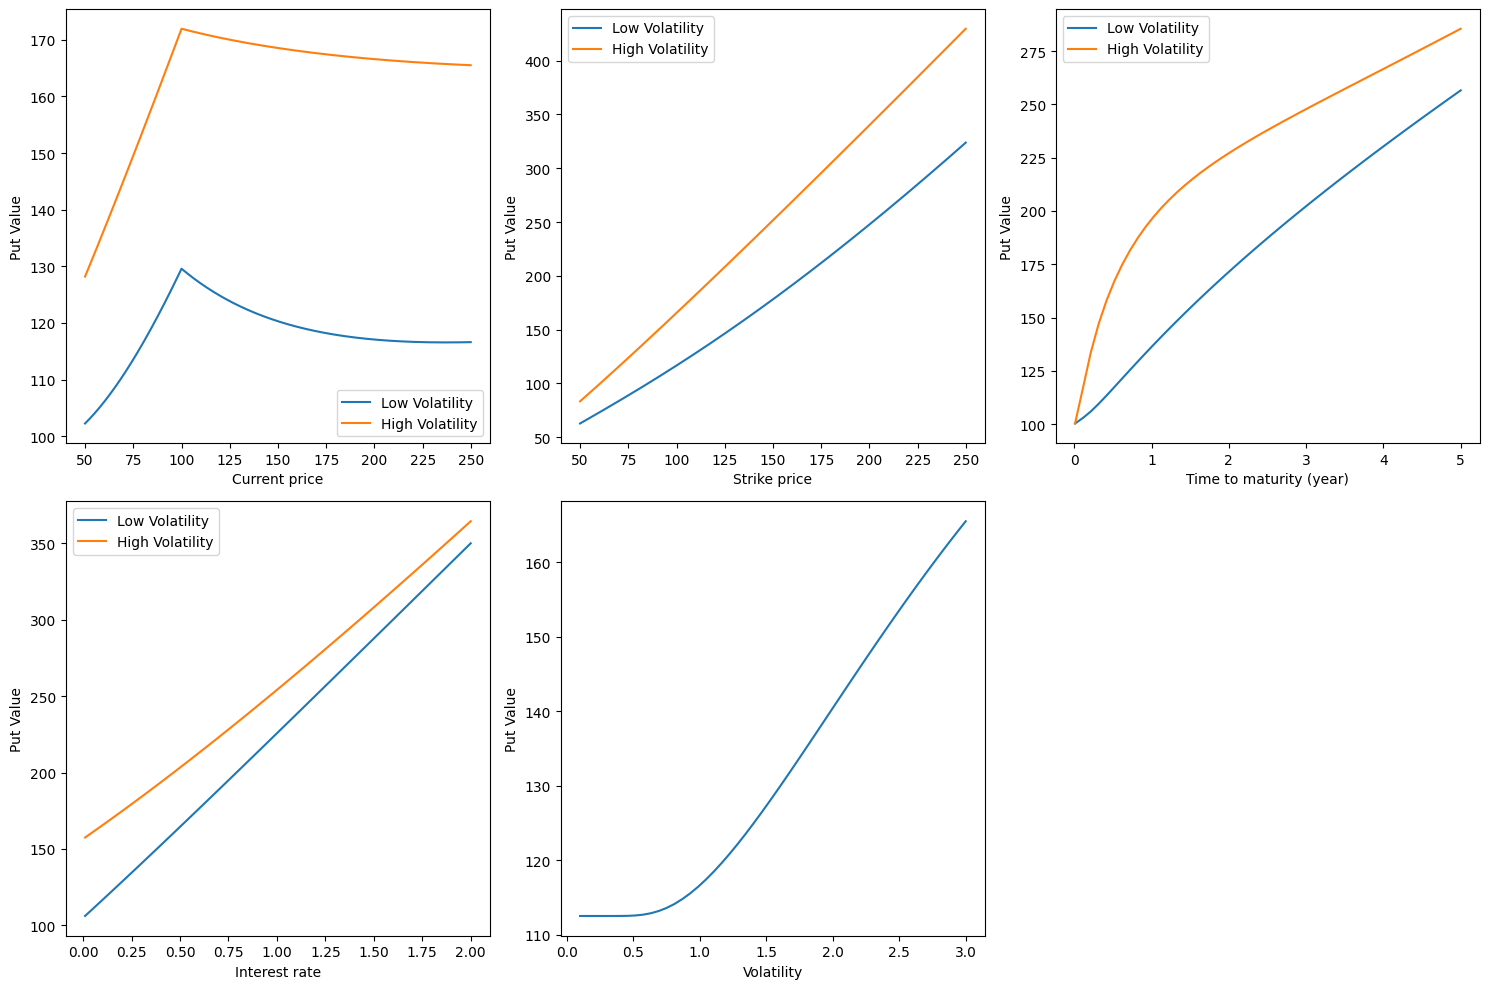

In [11]:
# Set base parameters
current_price = 250
strike_price = 100
interest_rate = 0.1
volatility = 0.3

# Create figure with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Vary current price
S = np.arange(50, 250, 0.1)
puts_low = [get_put_price(s, strike_price, time_to_maturity, interest_rate, volatility_low) for s in S]
puts_high = [get_put_price(s, strike_price, time_to_maturity, interest_rate, volatility_high) for s in S]
axes[0,0].plot(S, puts_low, label='Low Volatility')
axes[0,0].plot(S, puts_high, label='High Volatility')
axes[0,0].set_xlabel('Current price')
axes[0,0].set_ylabel('Put Value')
axes[0,0].legend()

# Vary strike price
K = np.arange(50, 250, 0.1)
puts_low = [get_put_price(current_price, k, time_to_maturity, interest_rate, volatility_low) for k in K]
puts_high = [get_put_price(current_price, k, time_to_maturity, interest_rate, volatility_high) for k in K]
axes[0,1].plot(K, puts_low, label='Low Volatility')
axes[0,1].plot(K, puts_high, label='High Volatility')
axes[0,1].set_xlabel('Strike price')
axes[0,1].set_ylabel('Put Value')
axes[0,1].legend()

# Vary time to maturity
maturities = np.linspace(0.01, 5)
puts_low = [get_put_price(current_price, strike_price, t, interest_rate, volatility_low) for t in maturities]
puts_high = [get_put_price(current_price, strike_price, t, interest_rate, volatility_high) for t in maturities]
axes[0,2].plot(maturities, puts_low, label='Low Volatility')
axes[0,2].plot(maturities, puts_high, label='High Volatility')
axes[0,2].set_xlabel('Time to maturity (year)')
axes[0,2].set_ylabel('Put Value')
axes[0,2].legend()

# Vary interest rate
rates = np.linspace(0.01, 2)
puts_low = [get_put_price(current_price, strike_price, time_to_maturity, r, volatility_low) for r in rates]
puts_high = [get_put_price(current_price, strike_price, time_to_maturity, r, volatility_high) for r in rates]
axes[1,0].plot(rates, puts_low, label='Low Volatility')
axes[1,0].plot(rates, puts_high, label='High Volatility')
axes[1,0].set_xlabel('Interest rate')
axes[1,0].set_ylabel('Put Value')
axes[1,0].legend()

# Vary volatility
vols = np.linspace(0.1, 3)
puts = [get_put_price(current_price, strike_price, time_to_maturity, interest_rate, v) for v in vols]
axes[1,1].plot(vols, puts)
axes[1,1].set_xlabel('Volatility')
axes[1,1].set_ylabel('Put Value')

# Remove unused subplot
fig.delaxes(axes[1,2])

plt.tight_layout()